In [1]:
%matplotlib inline

In [2]:
import numpy as np
import h5py
import matplotlib.pyplot as plt
from astropy.table import Table

In [3]:
data_dir = "/global/cfs/cdirs/lsst/groups/WL/users/zuntz/data"

cluster_catalog_file = f"{data_dir}/clmm-testing/cluster_catalog.hdf5"
cluster_shear_catalog_file = f"{data_dir}/clmm-testing/cluster_shear_catalogs.hdf5"
shear_catalog_file = f"{data_dir}/cosmoDC2-1.1.4_oneyear/metadetect_shear_catalog.hdf5"


In [4]:
# Load the cluster catalog from file
with h5py.File(cluster_catalog_file) as f:
    g = f['clusters']
    cluster_data = Table({
        col: g[col][:]
        for col in g.keys()
    })
cluster_data.pprint()

cluster_id         dec                 ra         ... richness_err  scaleval 
---------- ------------------- ------------------ ... ------------ ----------
        10 -25.717996124671657 52.520436430812914 ...    3.7469666  1.0001404
        18  -27.20434071042304 56.920376528125075 ...    3.6934361  1.0005391
        24   -26.7172081871169  56.99849698116052 ...    2.4172914   1.000476
        30 -27.429961828331713  58.56362402841767 ...    3.6777163  1.0015866
        71 -26.867687128773035  58.35519782866568 ...     3.366554  1.0000473
        73 -28.119101936484828  57.76575707007693 ...    2.9570596  1.0014223
       109 -26.989676182075844 58.509466974185045 ...    3.3524604  1.0021384
       116 -27.896589555863095 54.494027152041674 ...    2.2175314  1.0017645
       133 -27.199784884537003 58.137368555958155 ...      2.26323    1.00349
       151  -27.54965595251503  56.70614163063158 ...     2.411495  1.0007743
       ...                 ...                ... ...          .

In [5]:
# Load the full shear catalog.
with h5py.File(shear_catalog_file, "r") as shear_cat:
    ra_shear = shear_cat["shear/00/ra"][:]
    dec_shear = shear_cat["shear/00/dec"][:]
    g1 = shear_cat["shear/00/g1"][:]
    g2 = shear_cat["shear/00/g2"][:]


In [6]:
f = h5py.File(cluster_shear_catalog_file, "r")

# The first group in thie file, 'catalog', is ordered by cluster, and matches 1-1 with with the original cluster catalog.
# It tells you how many source galaxies are around each cluster, and where to find them in the other much larger
# group in this file, 'index', which tells us the index of each source in the full shear catalog.
cat_group = f['catalog']
index_group = f['index']


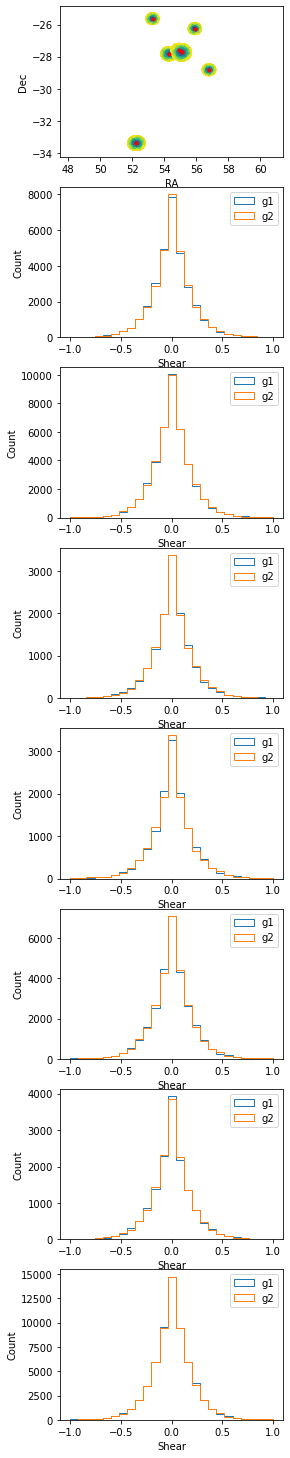

In [7]:
f, axes = plt.subplots(8, 1, figsize=(4,26))

# Let's choose a few random clusters and plot the catalog for them
for i, cindex in enumerate([1234, 5678, 910, 1112, 1314, 1516, 1718]):
    # This is the "index to the index". Sorry, weird I know,
    # but it's much faster to write it like this.
    # If you want the shear catalog for a given cluster you
    # first find out where in the index to searchm, like this:
    start = cat_group['cluster_sample_start'][cindex]
    n = cat_group['cluster_sample_count'][cindex]
    end = start + n

    # Now we can read from the main index what galaxies to look at for
    # this cluster.  First let's check that the cluster index correctly
    # says that these columns are all for the cluster we are curently looking at.
    assert (index_group['cluster_index'][start:end] == cindex).all()

    # Now some actually useful information - the index into the shear catalog
    # for this cluster:
    index = index_group['source_index'][start:end]
    weight = index_group['weight'][start:end]
    distance = index_group['distance_arcmin'][start:end]
    
    # Now we have this index we can just load the bits we need.
    # Reading randomly organized values in h5py is really slow - it would
    # take about 10 seconds per cluster to read the few hundred thousand ra and dec values.
    # To speed this we read the entire ra and dec catalog at once, which
    # is okay when it's just a few columns but might start to hurt if you want everything, especially
    # at Y1 scale. For the 400 sq deg this takes 6GB
    ra_sample = ra_shear[index]
    dec_sample = dec_shear[index]
    g1_sample = g1[index]
    g2_sample = g2[index]

    # Do a colour scatter plot with the distance of the galaxy from the cluster, to check it is working.
    # We expect to see the cluster as a red dot in the 
    axes[0].plot(cluster_data['ra'][cindex], cluster_data['dec'][cindex], 'r.')
    axes[0].scatter(ra_sample, dec_sample, s=1, c=distance)
    
    # Here let's just histogram the g1 and g2 for this example instead of doing a real calculation
    ax = axes[i + 1]
    ax.hist(g1_sample, histtype='step', label='g1', bins=25, range=(-1, 1))
    ax.hist(g2_sample, histtype='step', label='g2', bins=25, range=(-1, 1))
    ax.legend()
    ax.set_xlabel("Shear")
    ax.set_ylabel("Count")


axes[0].axis('equal');
axes[0].set_xlabel("RA")
axes[0].set_ylabel("Dec");
